# Initial analysis of the Kaggle dataset

In [53]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import re
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import openai
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D

* Nodes = tweets
* Edges = similarity between tweets based on meaning (embedding cosine similarity)

### Load the dataset and generate the network

In [18]:
df = pd.read_csv("/Users/ame/02805_climate_conv/data/twitter_sentiment_data.csv",
                 encoding="latin1",
                 on_bad_lines="skip")

df["message"] = df["message"].astype(str)

df = df[df["message"].str.strip().replace("nan", np.nan).notna()]

def clean_text(msg):
    msg = msg.lower()
    msg = re.sub(r"http\S+", "", msg)       # remove URLs
    msg = re.sub(r"rt\s*@\w+:", "", msg)    # remove RT prefix
    msg = re.sub(r"@\w+", "", msg)          # remove mentions
    msg = re.sub(r"#", "", msg)             # remove hashtags
    msg = re.sub(r"[^a-z0-9\s]", " ", msg)  # keep letters/numbers
    msg = re.sub(r"\s+", " ", msg).strip()
    return msg

df["clean_text"] = df["message"].apply(clean_text)

df = df[df["clean_text"].str.len() > 0]

def is_valid_unicode(x):
    try:
        x.encode("utf-8")
        return True
    except:
        return False

df = df[df["clean_text"].apply(is_valid_unicode)]

df = df[df["clean_text"].str.len() <= 8000]

df = df.reset_index(drop=True)

print("Final cleaned dataset:", df.shape)

Final cleaned dataset: (43918, 4)


In [19]:
# Build nearest-neighbor search over embeddings

EMBEDDINGS_PATH = "/Users/ame/02805_climate_conv/data/tweet_embeddings.npy"

embeddings = np.load(EMBEDDINGS_PATH)

print("Building nearest-neighbor index...")

k = 50  # number of neighbors

nn = NearestNeighbors(n_neighbors=k, metric="cosine")
nn.fit(embeddings)

distances, indices = nn.kneighbors(embeddings)

# Cosine similarity = 1 - cosine distance
similarities = 1 - distances

Building nearest-neighbor index...


In [34]:
THRESHOLD = 0.60
G = nx.Graph()

# Make sure tweetid matches node IDs (usually strings)
df["tweetid"] = df["tweetid"].astype(str)

# ---- 1) ADD NODES FIRST ----
for _, row in df.iterrows():
    tid = row["tweetid"]
    G.add_node(
        tid,
        tweetid=tid,
        sentiment=row["sentiment"],   # numeric
        message=row["message"],
        clean_text=row["clean_text"],
    )

# ---- 2) MAP NUMERIC SENTIMENT → LABEL ----
sentiment_map = {
    2: "news",
    1: "pro",
    0: "neutral",
    -1: "anti",
}

df["sentiment_label"] = df["sentiment"].map(sentiment_map)

# Build dict: tweetid → label
label_attr = df.set_index("tweetid")["sentiment_label"].to_dict()

# ---- 3) NOW ADD LABELS TO EXISTING NODES ----
nx.set_node_attributes(G, label_attr, "sentiment_label")

# ---- 4) ADD EDGES ----
edges_added = 0
print("Building network with similarity threshold =", THRESHOLD)

for i in range(len(df)):
    for j_idx, sim in zip(indices[i], similarities[i]):
        if sim >= THRESHOLD and i != j_idx:
            tid1 = df.loc[i, "tweetid"]
            tid2 = df.loc[j_idx, "tweetid"]
            G.add_edge(tid1, tid2, weight=float(sim))
            edges_added += 1


print("Network created.")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

nx.write_gexf(G, "/Users/ame/02805_climate_conv/networks/climate_tweet_network.gexf")
print("Graph saved to networks")

Building network with similarity threshold = 0.6
Network created.
Nodes: 43918
Edges: 819673
Graph saved to networks


### Desciption of the network

In [35]:
# Load network from file to G
G = nx.read_gexf("/Users/ame/02805_climate_conv/networks/climate_tweet_network.gexf")
print("Graph loaded from file")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Graph loaded from file
Nodes: 43918
Edges: 819673


In [36]:
# Print average degree
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)

Average degree: 37.327428389270914


In [37]:
# Max and min degree
degrees = dict(G.degree()).values()
print("Max degree:", max(degrees))
print("Min degree:", min(degrees))

Max degree: 1590
Min degree: 0


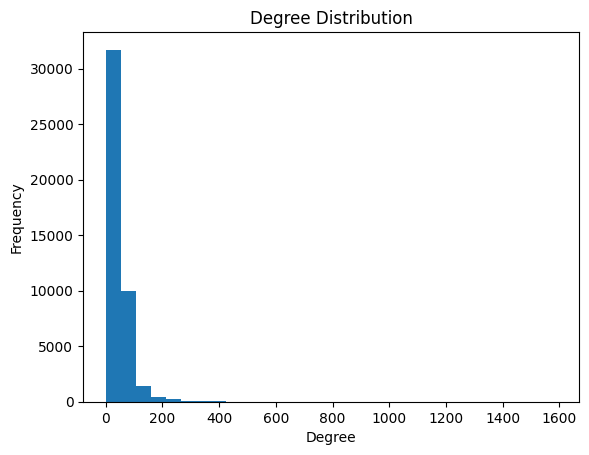

In [38]:
# Histogram of degree distribution
import matplotlib.pyplot as plt

plt.hist(degrees, bins=30)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [39]:
# Print number of nodes with 0 edges
num_isolated = sum(1 for node in G.nodes() if G.degree(node) == 0)
print("Number of nodes with 0 edges:", num_isolated)

Number of nodes with 0 edges: 3780


## Backboning and visualization

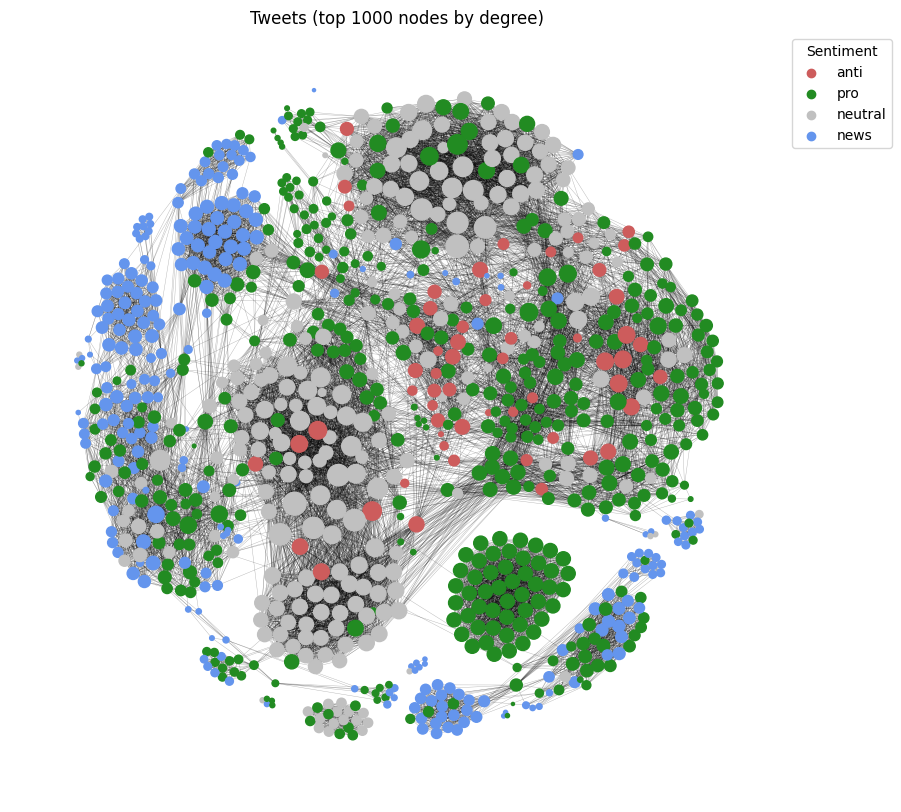

In [40]:
# Compute degrees
deg = dict(G.degree())

top_nodes = sorted(deg, key=deg.get, reverse=True)[:1000]

# Induced subgraph on those nodes
H = G.subgraph(top_nodes).copy()

# Recompute degrees on the subgraph
deg_H = dict(H.degree())
node_sizes = [5 + 2 * deg_H[n] for n in H.nodes()]  # tweak for better visualization

# Emotion labels used by your model
sentiment_label = ["news", "pro", "neutral", "anti"]

# Pick a distinct color for each emotion
sentiment_colors = {
    "anti":      "indianred",  
    "pro":       "forestgreen",  
    "neutral":   "silver", 
    "news":      "cornflowerblue", 
}

# Node colors: based on sentiment_label attribute
node_colors = [
    sentiment_colors.get(H.nodes[n].get("sentiment_label"), "#7f7f7f")
    for n in H.nodes()
]
# Layout on the subgraph
pos = nx.forceatlas2_layout(
    H,
    pos=None,
    max_iter=1000,
    distributed_action=False,
    strong_gravity=True
)

plt.figure(figsize=(10, 10))

# Draw only edges between the top-1000 nodes
nx.draw_networkx_edges(H, pos, width=0.3, alpha=0.3)

# Draw only the top-1000 nodes
nodes = nx.draw_networkx_nodes(
    H,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
)

# manual legend for emotions
for sentiment, color in sentiment_colors.items():
    plt.scatter([], [], c=color, label=sentiment)

plt.legend(
    title="Sentiment",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)

#plt.colorbar(nodes, label="content_length (words)", ax=plt.gca(), fraction=0.03)
plt.axis('off')
plt.title("Tweets (top 1000 nodes by degree)")
plt.show()


Largest connected component nodes: 907
Largest connected component edges: 15417


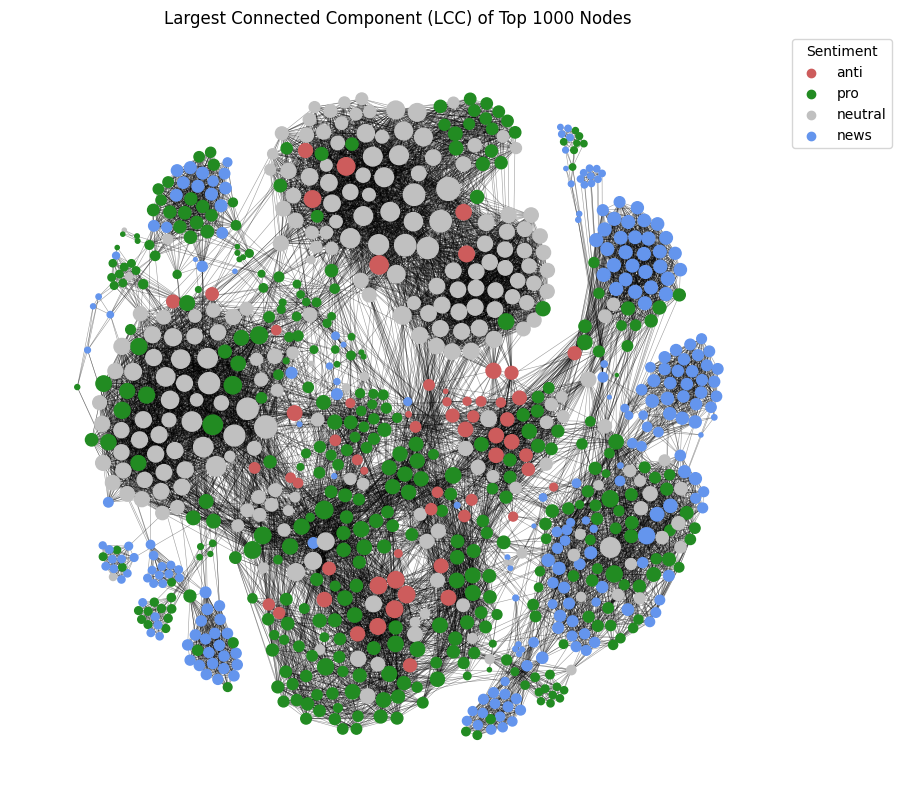

In [57]:
# Plot the largest connected component from the top 1000 nodes only
largest_cc = max(nx.connected_components(H), key=len)
SG = H.subgraph(largest_cc).copy()
print("Largest connected component nodes:", SG.number_of_nodes())
print("Largest connected component edges:", SG.number_of_edges())
pos = nx.forceatlas2_layout(    
    SG,
    seed=42,
    pos=None,
    max_iter=1000,
    distributed_action=False,
    strong_gravity=True
)
plt.figure(figsize=(10, 10))
# Node sizes (degree-based within this reduced subgraph)
deg = dict(SG.degree())
node_sizes = [3 + 2 * deg[n] for n in SG.nodes()]
# Draw nodes + edges
nx.draw_networkx_edges(SG, pos, width=0.4, alpha=0.4)
nodes = nx.draw_networkx_nodes(
    SG, pos,
    node_size=node_sizes,
    node_color=[
        sentiment_colors.get(SG.nodes[n].get("sentiment_label"), "#7f7f7f")
        for n in SG.nodes()
    ],
)
# manual legend for emotions
for sentiment, color in sentiment_colors.items():
    plt.scatter([], [], c=color, label=sentiment)
plt.legend(
    title="Sentiment",
    loc="upper left",
    bbox_to_anchor=(1, 1)
)
plt.axis('off')
plt.title("Largest Connected Component (LCC) of Top 1000 Nodes")
plt.show()

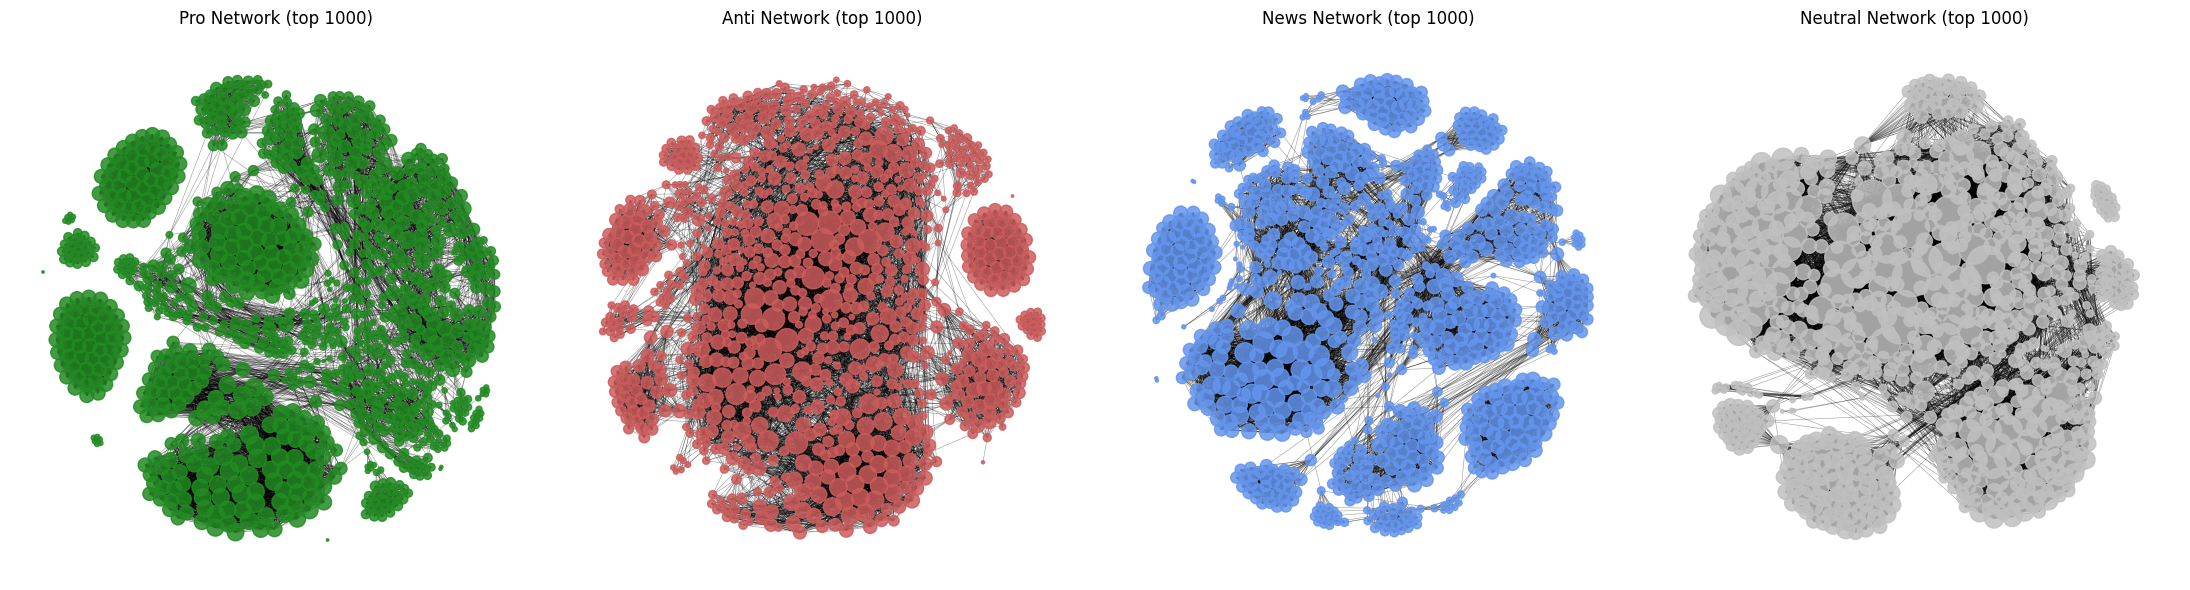

In [42]:
import matplotlib.pyplot as plt
import networkx as nx

# ---- 1) Build four subnetworks from sentiment_label ----
sentiments = ["pro", "anti", "news", "neutral"]

subgraphs = {
    s: G.subgraph([
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == s
    ]).copy()
    for s in sentiments
}

# ---- 2) Colors for each graph ----
sentiment_colors = {
    "anti":      "indianred",  
    "pro":       "forestgreen",  
    "neutral":   "silver", 
    "news":      "cornflowerblue", 
}

# ---- 3) Plot the four networks next to each other ----
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, sentiment in zip(axes, sentiments):
    SG_full = subgraphs[sentiment]

    # Skip empty subgraphs just in case
    if SG_full.number_of_nodes() == 0:
        ax.set_title(f"{sentiment.capitalize()} Network (no nodes)")
        ax.set_axis_off()
        continue

    # --- Take top 1000 nodes by degree *within this sentiment subgraph* ---
    deg_full = dict(SG_full.degree())
    top_nodes = sorted(deg_full, key=deg_full.get, reverse=True)[:1000]

    SG = SG_full.subgraph(top_nodes).copy()

    # Layout for THIS reduced subgraph
    pos = nx.forceatlas2_layout(
        SG,
        seed=42,
        pos=None,
        max_iter=1000,
        distributed_action=False,
        strong_gravity=True
    )

    # Node sizes (degree-based within this reduced subgraph)
    deg = dict(SG.degree())
    node_sizes = [3 + 2 * deg[n] for n in SG.nodes()]

    # Draw nodes + edges
    nx.draw_networkx_edges(SG, pos, ax=ax, width=0.4, alpha=0.4)
    nx.draw_networkx_nodes(
        SG,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=sentiment_colors[sentiment],
        alpha=0.85
    )

    ax.set_title(f"{sentiment.capitalize()} Network (top 1000)")
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Detect emotions

In [43]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

MODEL = "cardiffnlp/twitter-roberta-base-emotion"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# model returns logits for these labels:
EMOTION_LABELS = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

In [ ]:
def get_emotion(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return None, None

    # tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    # get model output
    with torch.no_grad():
        logits = model(**inputs).logits

    # softmax for probabilities
    probs = torch.softmax(logits, dim=1).numpy()[0]

    # get top emotion
    top_idx = np.argmax(probs)
    top_emotion = EMOTION_LABELS[top_idx]

    return top_emotion, dict(zip(EMOTION_LABELS, probs))

In [48]:
# Print the first clean text of the dataframe
print(df["clean_text"].iloc[2])

fabulous leonardo dicaprio s film on climate change is brilliant do watch via


In [50]:
top_nodes_by_sentiment = {}

for category in ["pro", "anti", "news", "neutral"]:
    # Filter nodes in this sentiment group
    nodes_in_group = [
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == category
    ]

    # Sort these nodes by degree
    top_nodes = sorted(
        nodes_in_group,
        key=lambda n: deg.get(n, 0),
        reverse=True
    )[:1000]

    top_nodes_by_sentiment[category] = top_nodes

selected_nodes = (
    top_nodes_by_sentiment["pro"] +
    top_nodes_by_sentiment["anti"] +
    top_nodes_by_sentiment["news"] +
    top_nodes_by_sentiment["neutral"]
)

df_subset = df[df["tweetid"].isin(selected_nodes)].copy()
print("Selected tweets:", len(df_subset))

emotions = []
emotion_probs = []

for row in df_subset.itertuples(index=False):
    emotion, prob_dict = get_emotion(row.clean_text)
    emotions.append(emotion)
    emotion_probs.append(prob_dict)

df_subset["emotion"] = emotions
df_subset["emotion_probs"] = emotion_probs


Selected tweets: 4000


In [51]:
# Make sure tweetid matches node IDs (string)
df_subset["tweetid"] = df_subset["tweetid"].astype(str)

# Build mapping: tweetid -> emotion
emotion_attr = df_subset.set_index("tweetid")["emotion"].to_dict()

# Build mapping: tweetid -> emotion_probs (dict of 6 probs)
emotion_probs_attr = df_subset.set_index("tweetid")["emotion_probs"].to_dict()

# Attach as node attributes on G
nx.set_node_attributes(G, emotion_attr, "emotion")
nx.set_node_attributes(G, emotion_probs_attr, "emotion_probs")

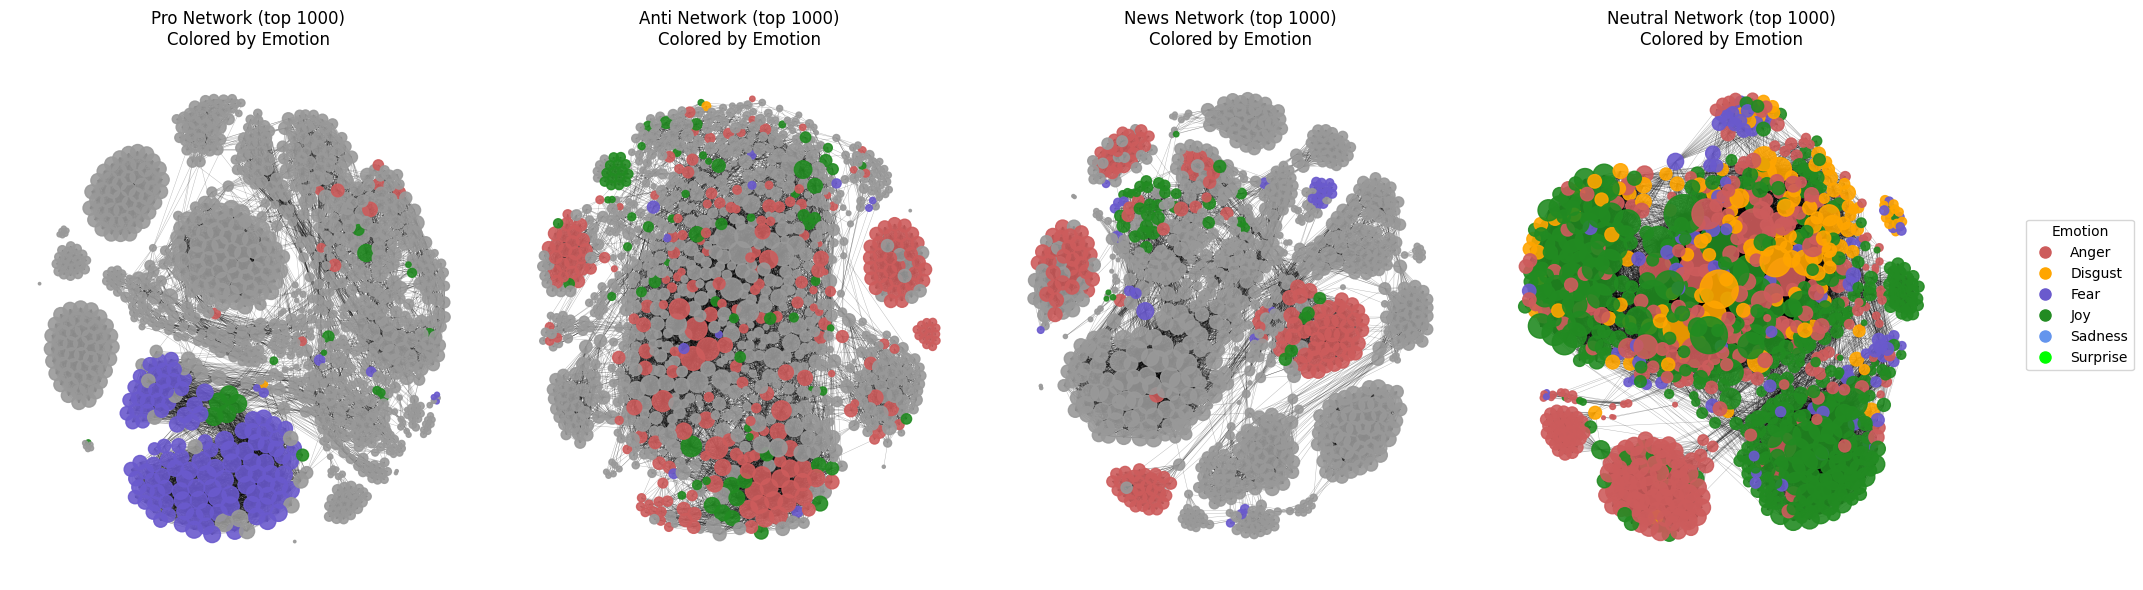

In [56]:
# ---- 1) Build four subnetworks based on sentiment_label ----
sentiments = ["pro", "anti", "news", "neutral"]

subgraphs = {
    s: G.subgraph([
        n for n in G.nodes()
        if G.nodes[n].get("sentiment_label") == s
    ]).copy()
    for s in sentiments
}

# ---- 2) Emotion colors ----
emotion_colors = {
    "anger":    "indianred",
    "disgust":  "orange",
    "fear":     "slateblue",
    "joy":      "forestgreen",
    "sadness":  "cornflowerblue",
    "surprise": "lime",
}

# ---- 3) Plot the four networks next to each other ----
fig, axes = plt.subplots(1, 4, figsize=(22, 6))

for ax, sentiment in zip(axes, sentiments):
    SG_full = subgraphs[sentiment]

    if SG_full.number_of_nodes() == 0:
        ax.set_title(f"{sentiment.capitalize()} Network (no nodes)")
        ax.set_axis_off()
        continue

    # Top 1000 nodes by degree (within this sentiment group)
    deg_full = dict(SG_full.degree())
    top_nodes = sorted(deg_full, key=deg_full.get, reverse=True)[:1000]
    SG = SG_full.subgraph(top_nodes).copy()

    # Layout
    pos = nx.forceatlas2_layout(
        SG,
        seed=42,
        max_iter=1000,
        distributed_action=False,
        strong_gravity=True
    )

    # Node sizes
    deg = dict(SG.degree())
    node_sizes = [3 + 2 * deg[n] for n in SG.nodes()]

    # Node colors based on EMOTION
    node_colors = [
        emotion_colors.get(G.nodes[n].get("emotion"), "#999999")
        for n in SG.nodes()
    ]

    # Draw network
    nx.draw_networkx_edges(SG, pos, ax=ax, width=0.3, alpha=0.3)
    nx.draw_networkx_nodes(
        SG,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9
    )

    ax.set_title(f"{sentiment.capitalize()} Network (top 1000)\nColored by Emotion")
    ax.set_axis_off()

# ---- 4) Add one shared legend on the right ----
legend_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="",
        markersize=8,
        color=color,
        label=emotion.capitalize()
    )
    for emotion, color in emotion_colors.items()
]

# Make room on the right for the legend
plt.tight_layout(rect=[0, 0, 0.9, 1])

fig.legend(
    handles=legend_handles,
    title="Emotion",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5)
)

plt.show()


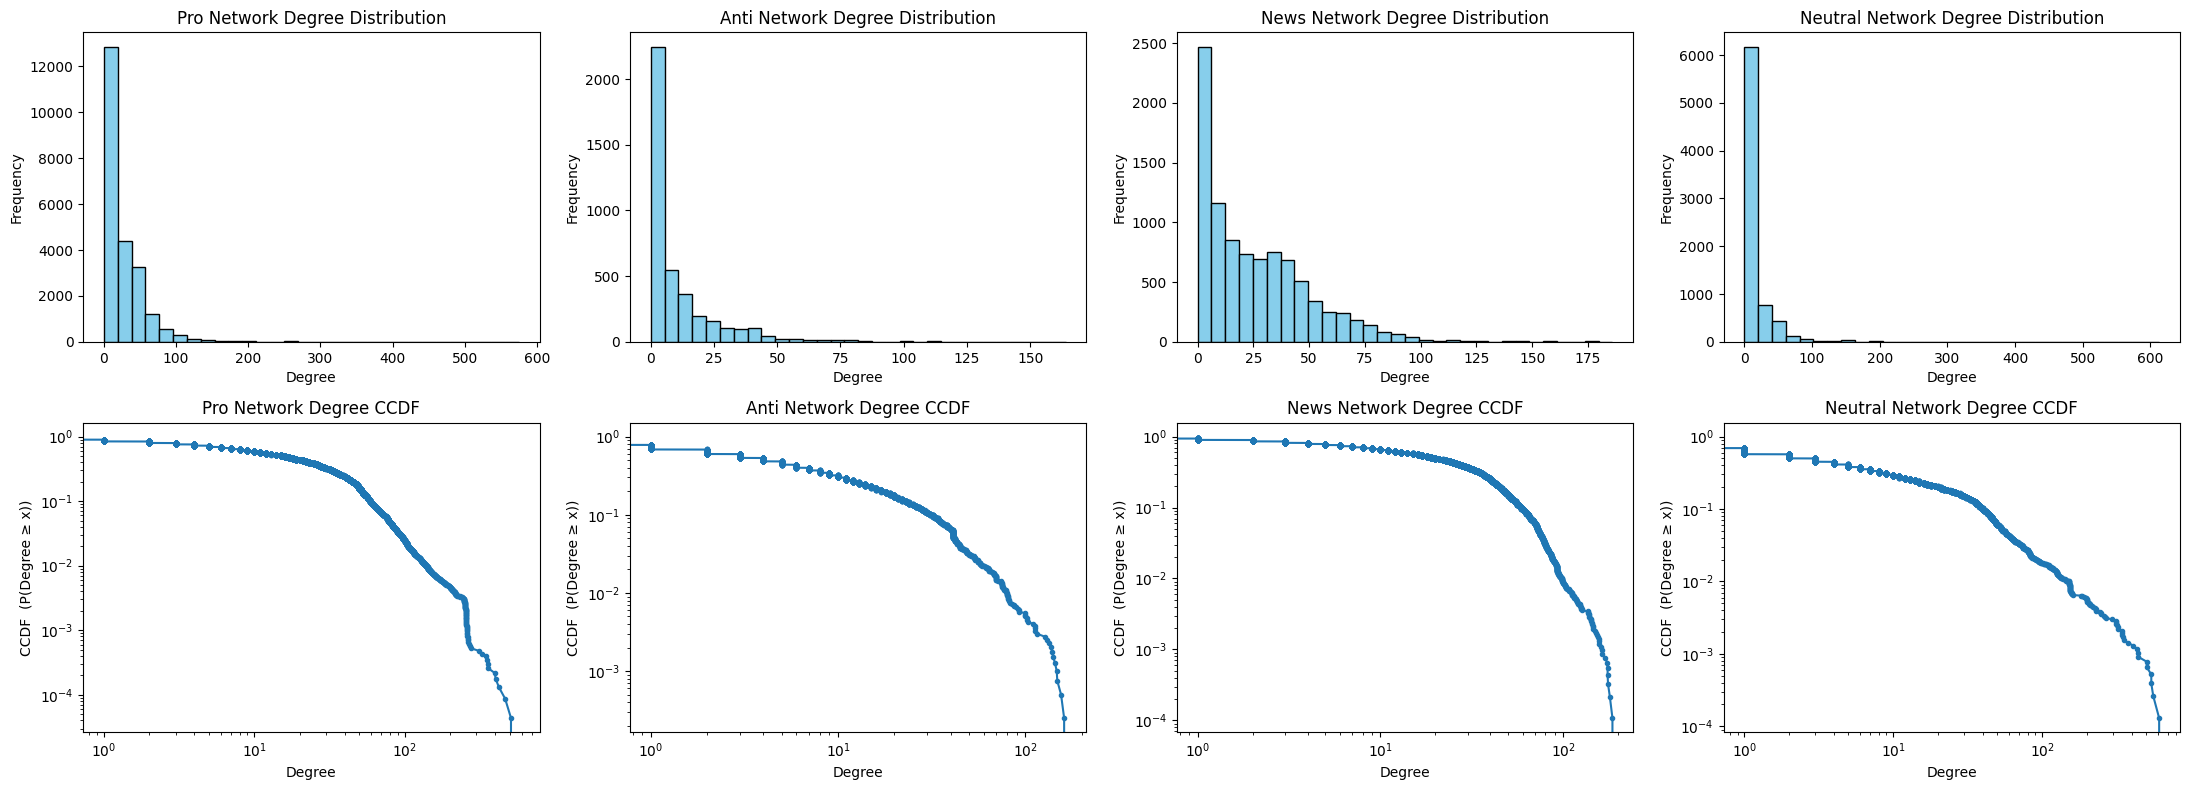

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def compute_ccdf(data):
    data = np.array(data)
    data = np.sort(data)
    n = len(data)
    # CCDF: P(X ≥ x)
    ccdf = 1.0 - np.arange(1, n + 1) / n
    return data, ccdf

# Plot: top row = histograms, bottom row = CCDFs
fig, axes = plt.subplots(2, 4, figsize=(22, 8))

for col, sentiment in enumerate(sentiments):
    SG = subgraphs[sentiment]

    if SG.number_of_nodes() == 0:
        axes[0, col].set_title(f"{sentiment.capitalize()} Network (no nodes)")
        axes[0, col].set_axis_off()
        axes[1, col].set_axis_off()
        continue

    degrees = [d for _, d in SG.degree()]

    # --- Top row: histogram ---
    ax_hist = axes[0, col]
    ax_hist.hist(degrees, bins=30, color="skyblue", edgecolor="black")
    ax_hist.set_title(f"{sentiment.capitalize()} Network Degree Distribution")
    ax_hist.set_xlabel("Degree")
    ax_hist.set_ylabel("Frequency")

    # --- Bottom row: CCDF ---
    ax_ccdf = axes[1, col]
    x, y = compute_ccdf(degrees)
    ax_ccdf.plot(x, y, marker=".", linestyle="-")
    ax_ccdf.set_xlabel("Degree")
    ax_ccdf.set_ylabel("CCDF  (P(Degree ≥ x))")
    ax_ccdf.set_title(f"{sentiment.capitalize()} Network Degree CCDF")

    # Optional: use log scale if you like (often helpful for degree)
    ax_ccdf.set_xscale("log")
    ax_ccdf.set_yscale("log")

plt.tight_layout()
plt.show()
